In [2]:
import sys
import requests
from bs4 import BeautifulSoup
import pandas
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.special import comb
from scipy.stats import spearmanr
import statistics

**Created by:** Saumya Sharma, ss2944@cornell.edu
**Date:** June 12, 2020

# Introduction

## Abstract

### Purpose
In the following report, we attempt to identify if any realtionship exists between the number of push notifications sent to users and the number of app opens. Specifically, we address the following questions:
* How does sending mass messages impact the number of app opens?
* How does sending individualized messages impact the number of app opens?
* How does seasonality and day of the week impact app opens?

### Findings
The following are the key findings and takeaways from the report:
* `App Opens` follows an inverse logarithmic curve with a two spikes, July and March.
* Certain mass send dates directly trigger mass app opens, while certain ones are unsuccessful.
* While there is not enough data on tailored sends, there appears to be a strong correlation with `App Opens`.
* Saturday and Sunday have the least number of `App Opens` while Tuesday usually has the most in any given week.
* Winter is the least popular season for `App Opens` (appx. 55 opens), while Summer is the most popular season (avg. of 125 `App Opens`).

### Next Steps
* Identify the events that triggered the two spikes in `App Opens`.
* Determine the relationship between mass sends that were successful and unsuccessful.
* Send more tailored messages and monitor the response.



## Composition 
### Dataset Overview
The dataset contains following attributes: Date, Sends, App Opens.

The observations span from June 1, 2019 - May 31, 2020.

This data is designed to be extrapolated across time and applied to future strategy for PepTalkHer. This data will remain relevant if the PepTalkHer demographic remains consistent, and for as long as PepTalkHer is in its growth phase. It cannot be extraploted externally or be used in strategies beyond analyzing PepTalkHer app user behavior.

### Dataset Source
The source of the dataset is Urban Airship. People are most likely aware of the data collection and usage, and users are not identified on an individual level.

### Data Preparation and Preprocessing
This data was created by Urban Airship. 
* Sends is defined as total notifications sent during a specific time period. Count includes alerting sends only; silent sends (via silent push notifications) are ignored.
* Total app opens are calcuated during a specific time period. Count includes repeated app opens by individual users.

### Potential Influences on the Data
* We look at total app opens instead of unique app opens to account for situations in which two notifications were sent on the same day and both of these notifications impacted users opening the app. 
* A user may be opening an app multiple times during the day. If this behavior is consistent, or the sample size is large enough, the impact will be negligible.
* Any external brand awareness campaign, such as a PepTalkHer event, media coverage on the organization, or customer workshop may cause a spike in users. However, by capturing an entire's year worth of data, we might be able to spot anomolies.
* General growth in users and in messages sent may impact the data.

# Creating Datasets

In [3]:
monthlist=['jun','jul','aug','sept','oct','nov','dec','jan','feb','mar','apr','may']
typelist=['1','2']
t='Time In App'
#Creating Year Dataframe
ydf=pandas.DataFrame()
for i in range(len(monthlist)):
    for n in [0,1]:
        filename=monthlist[i]+typelist[n]+'.csv'
        ydf=pandas.concat([ydf, pandas.read_csv(filename)])
ydf.reset_index(drop=True, inplace=True)
ydf=ydf.drop(['APP Key','Project Name', t], axis=1)
ydf.head()

,Date,Sends,App Opens
0,2019-06-01,0,12
1,2019-06-02,0,37
2,2019-06-03,0,16
3,2019-06-04,0,25
4,2019-06-05,0,58


In [4]:
def monthdf(m):
    #Purpose: This function creates the data set for a given month
    
    #m is type string name of the month as listed in the monthlist list
    mdf=pandas.DataFrame()
    
    for n in [0,1]:
        #creating the dataframe
        filename= m + typelist[n] + '.csv'
        mdf=pandas.concat([mdf, pandas.read_csv(filename)])
    mdf.reset_index(drop=True, inplace=True)
    return mdf.drop(['APP Key','Project Name', t], axis=1)

jundf=monthdf('jun')
juldf=monthdf('jul')
augdf=monthdf('aug')
septdf=monthdf('sept')
octdf=monthdf('oct')
novdf=monthdf('nov')
decdf=monthdf('dec')
jandf=monthdf('jan')
febdf=monthdf('feb')
mardf=monthdf('mar')
aprdf=monthdf('apr')
maydf=monthdf('may')

monthdata=[jundf, juldf,augdf, septdf, octdf, novdf, decdf, jandf, febdf, mardf, aprdf, maydf]

# Observations from Visual Representation of the Data

## Yearly `Sends`

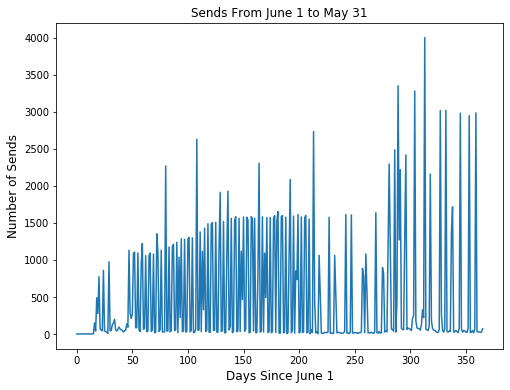

In [5]:
plt.figure(figsize=(8, 6))
plt.plot(ydf['Sends'])
plt.ylabel('Number of Sends', fontsize=12)
plt.xlabel('Days Since June 1', fontsize=12)
plt.title('Sends From June 1 to May 31', fontsize=12)
plt.show()

The graph above contains the following pattern:
* A general trend increase in number of sends from 1500 to 3000
* Time between sends increasing after approximately 220 days
* Smaller, non-zero sends after 220 days indicates increased message tailoring

## Yearly `App Opens`

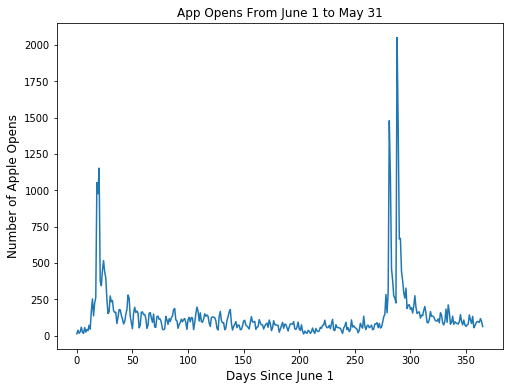

In [6]:
plt.figure(figsize=(8, 6))
plt.title('App Opens From June 1 to May 31', fontsize=12)
plt.ylabel('Number of Apple Opens', fontsize=12)
plt.xlabel('Days Since June 1', fontsize=12)
plt.plot(ydf['App Opens'])
plt.show()

This visual analysis allows us to note:
* General trend of mass, and logarithmic decline until only regular users remain
* Data outliers, the end of the July and before March indicate some external catalyst
* General up and down trend on a smaller scope, indicating a potential weekly cyclicality

## `Sends` Impact on `App Opens`

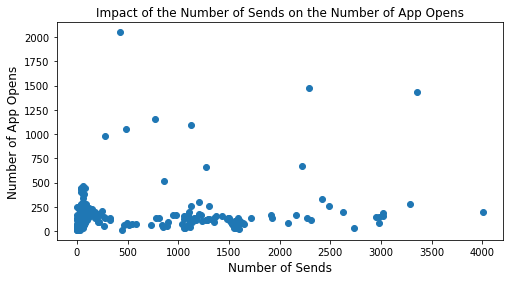

In [7]:
plt.figure(figsize=(8, 4))
plt.scatter(ydf['Sends'], ydf['App Opens'])
plt.xlabel('Number of Sends', fontsize=12)
plt.ylabel('Number of App Opens', fontsize=12)
plt.title('Impact of the Number of Sends on the Number of App Opens', fontsize=12)
plt.show()

From this we notice the following:
* We can spot the outliers in `App Opens` 
* No obvious trend exists, but can attempt to look specifically at the values less than 2000 since that's were most of the data lies
* Data at 0 could serve as a control group

## Monthly `Sends` and `App Opens`

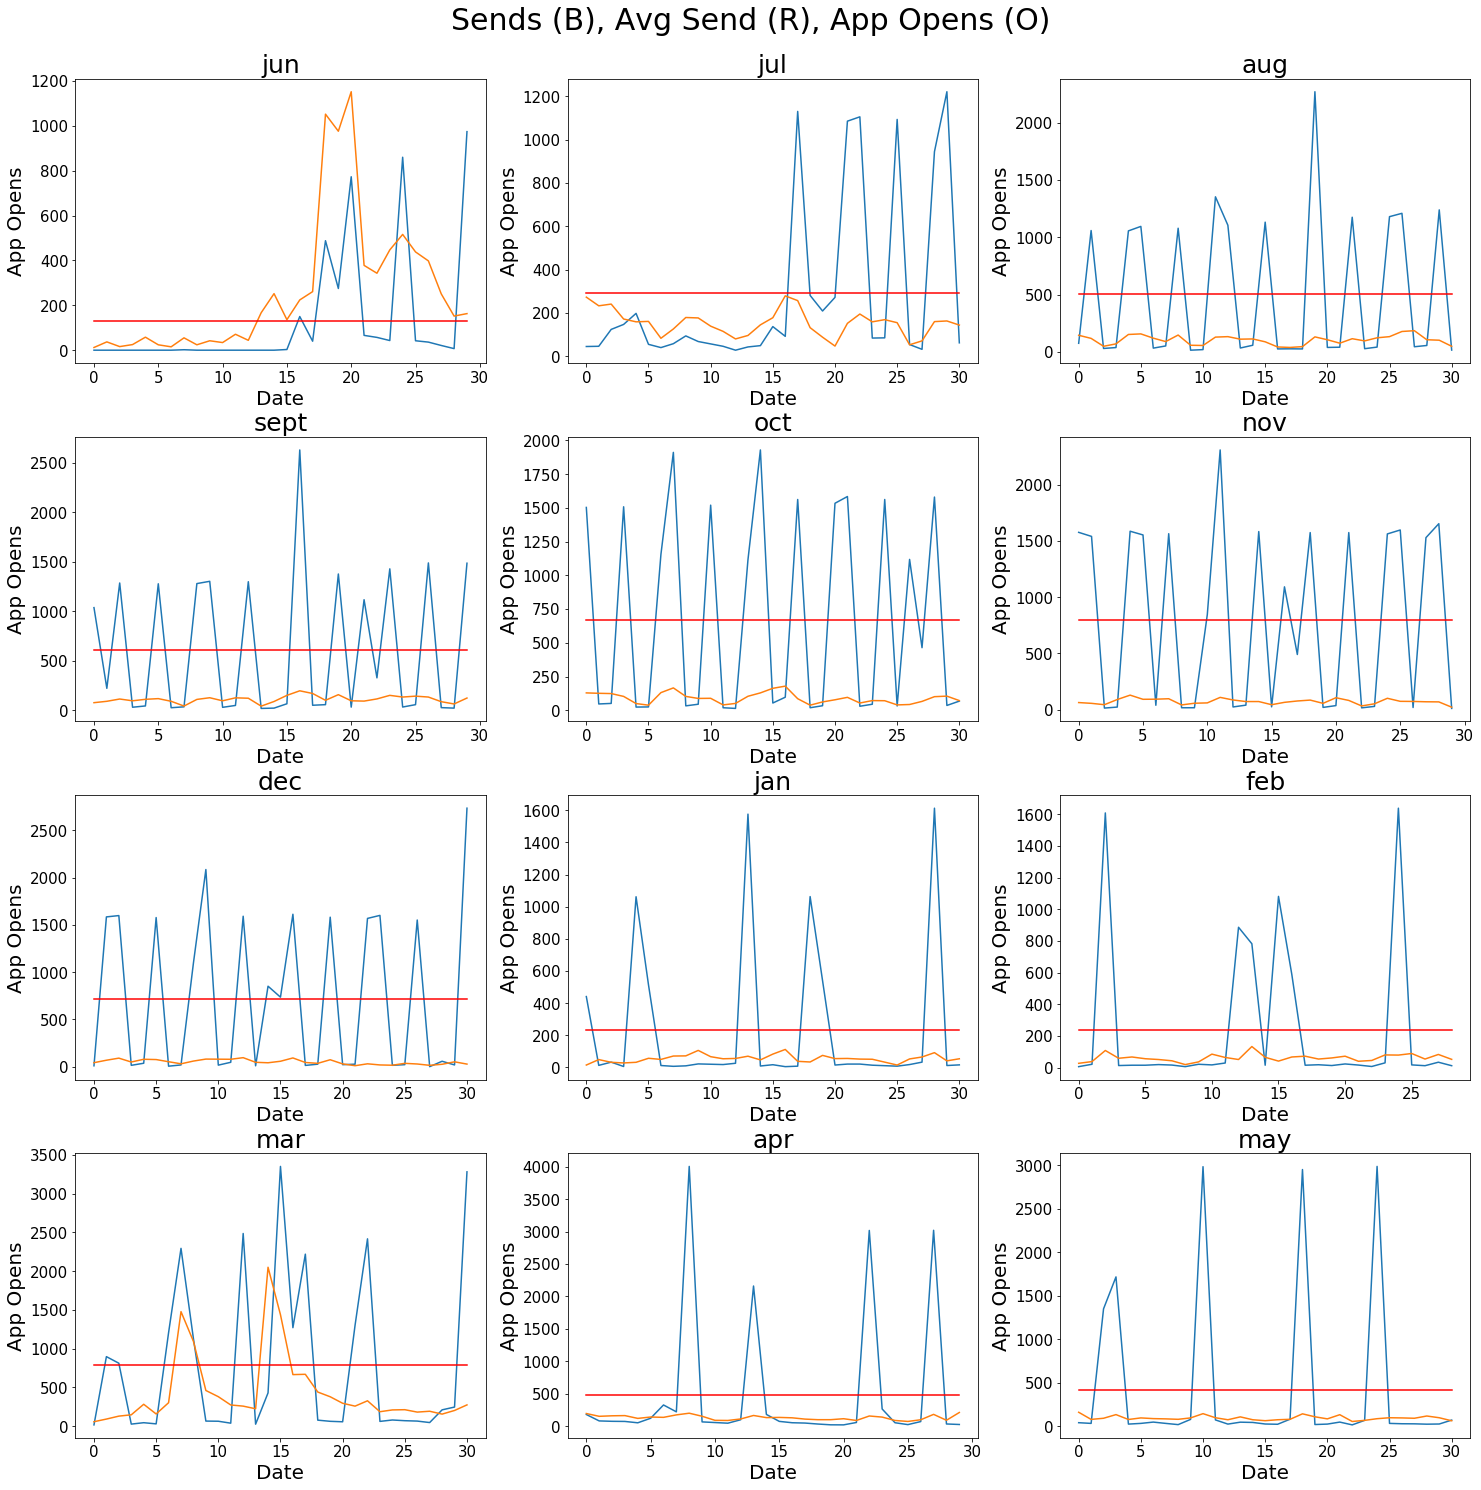

In [8]:
xaxs = 0
yaxs = 0

fig, axs = plt.subplots(4, 3, figsize=(25, 25))
fig.suptitle('Sends (B), Avg Send (R), App Opens (O)', 
             fontsize=30,y=.92)

i = 0
for m in monthdata:

    axs[xaxs, yaxs].plot(m['Sends'])
    axs[xaxs, yaxs].plot(m['App Opens'])
    axs[xaxs, yaxs].set_title(monthlist[i],fontsize=25)
    axs[xaxs, yaxs].set_xlabel('Date',fontsize=20)
    axs[xaxs, yaxs].set_ylabel('App Opens',fontsize=20)
    axs[xaxs, yaxs].tick_params(labelsize=15)
    
    #printing a mean line
    x = list(m.index.values)
    y = [m['Sends'].mean()]*len(x)
    axs[xaxs, yaxs].plot(x, y, color='red') 
        
    
    i+=1
    yaxs +=1
    if yaxs == 3:
        yaxs = 0
        xaxs +=1
plt.subplots_adjust(hspace=.26)        
plt.show()

From this, we observe the following:
* In June and March, we notice the the anomalous `App Opens` data
* Verification of the trend noted before that certain message sends were tailored, while largers spikes are not
* The mean of `Sends` is a good differentiator between mass message sends and tailored messages

From here we can determine the impact of sending mass sends and of tailored messages on app opens

# Relationship Between Mass Sends and Apps Open

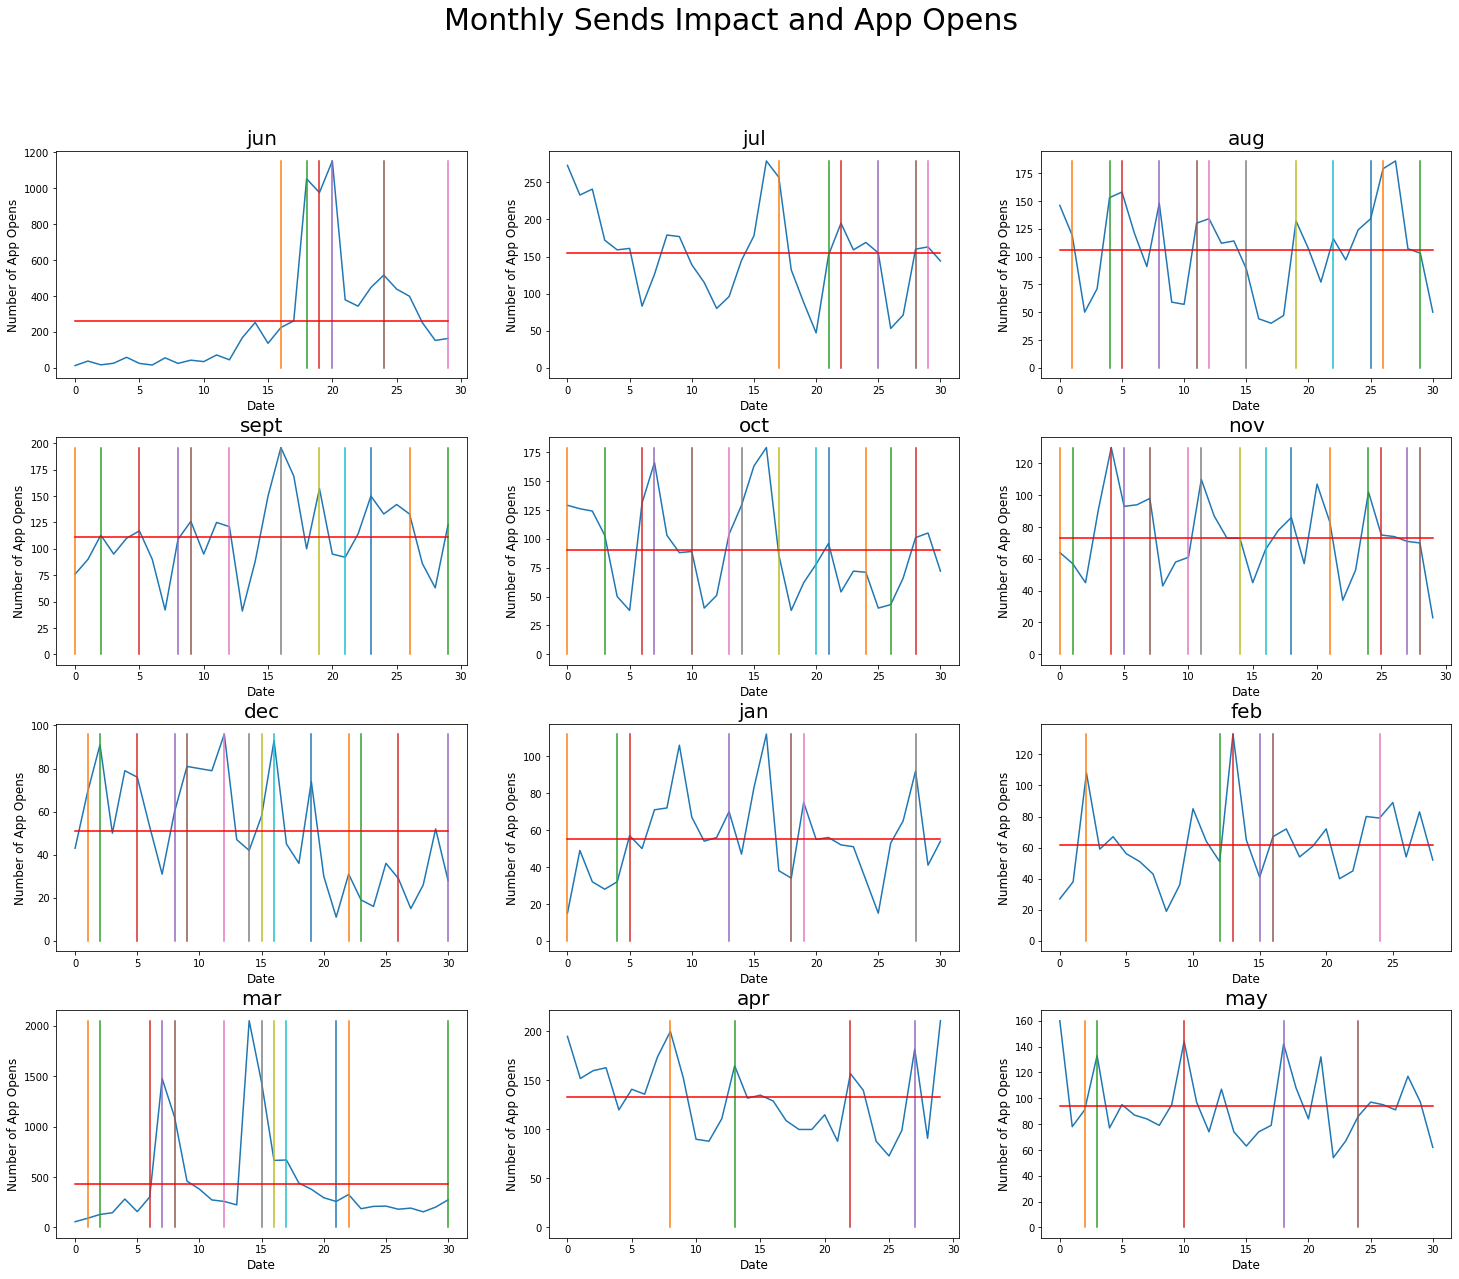

In [9]:
xaxs = 0
yaxs = 0

fig, axs = plt.subplots(4, 3, figsize=(25, 20))
fig.suptitle('Monthly Sends Impact and App Opens', fontsize=30)

i = -1

for m in monthdata:
    i +=1
    mean = m['Sends'].mean()
    fdf=m[m['Sends']>mean][:]
    
    #printing App Open Data
    axs[xaxs, yaxs].plot(m['App Opens'])
    axs[xaxs, yaxs].set_ylabel('Number of App Opens', fontsize=12)
    axs[xaxs, yaxs].set_xlabel('Date', fontsize=12)
    #Printing Vertical "Spike" Lines
    for s in list(fdf.index.values):
        x =[s]*2
        y = np.linspace(0,max(m['App Opens']),2)
        axs[xaxs, yaxs].plot(x,y)
     
    #printing mean line for # App Opens <--- BUH WHY
    x = list(range(len(m)))
    y1 = [m['App Opens'].mean()]*len(x)
    axs[xaxs, yaxs].plot(x, y1, color='red')
    
    axs[xaxs, yaxs].set_title(monthlist[i],fontsize=20)
    
    yaxs +=1
    if yaxs == 3:
        yaxs = 0
        xaxs +=1

plt.subplots_adjust(hspace=.26)           
        
plt.show()

We can see that certain messages directly correlate with a peak and certain messages do not.

* The vertical lines indicate mass send dates. These dates are determined by finding which days have `Sends` greater than the average number of `Sends` for the month. This is designed to represent days when mass sends occurred.

* The horizontal line represents the average number of `App Opens` for the month. 

By mapping the lines above on the `App Opens` graph, we can isolate the peaks in the `App Opens` graph that directly overlay with mass `Sends` and determine which mass `Sends` were most effective.


## Isolating the Dates Where Mass `Sends` Were Most Successful in Increasing `App Opens`

In [10]:
success=[]
unsuccess=[]

for m in monthdata:
    sendmean = m['Sends'].mean()
    appopenmean = m['App Opens'].mean()
    fdf=m[m['Sends']>mean][:]
    
    for index in list(fdf.index.values):
        if m['App Opens'].iloc[index] > appopenmean:
            success.append(m['Date'].iloc[index])
        else:
            unsuccess.append(m['Date'].iloc[index])
            
print('The following were dates during which mass sends were successful in increasing app opens')
print(success)
print()
print('The following were dates were unsuccessful')
print(unsuccess)

The following were dates during which mass sends were successful in increasing app opens
['2019-06-19', '2019-06-21', '2019-06-25', '2019-07-18', '2019-07-23', '2019-07-26', '2019-07-29', '2019-07-30', '2019-08-02', '2019-08-05', '2019-08-06', '2019-08-09', '2019-08-12', '2019-08-13', '2019-08-20', '2019-08-23', '2019-08-26', '2019-08-27', '2019-09-03', '2019-09-06', '2019-09-10', '2019-09-13', '2019-09-17', '2019-09-20', '2019-09-24', '2019-09-27', '2019-09-30', '2019-10-01', '2019-10-04', '2019-10-07', '2019-10-08', '2019-10-14', '2019-10-15', '2019-10-22', '2019-10-29', '2019-11-05', '2019-11-06', '2019-11-08', '2019-11-12', '2019-11-18', '2019-11-19', '2019-11-22', '2019-11-25', '2019-11-26', '2019-12-02', '2019-12-03', '2019-12-06', '2019-12-09', '2019-12-10', '2019-12-13', '2019-12-16', '2019-12-17', '2019-12-20', '2020-01-06', '2020-01-14', '2020-01-20', '2020-01-29', '2020-02-03', '2020-02-14', '2020-02-17', '2020-02-25', '2020-03-08', '2020-03-09', '2020-03-15', '2020-03-16', 

## Next Steps
To implement this data into a final strategy, these are the following steps:
* Identify the messages that correspond to these mass sends and determine if they have common characteristics
* Identify if these dates share any important characteristics (i.e. all are Fridays)
* Identify any other possible relationship that could tie these dates together

# Tailored `Sends` and Apps Opens
To identify the impact of more tailored messaging, we can remove the data points that represent mass `Sends` and compare it with `App Opens`

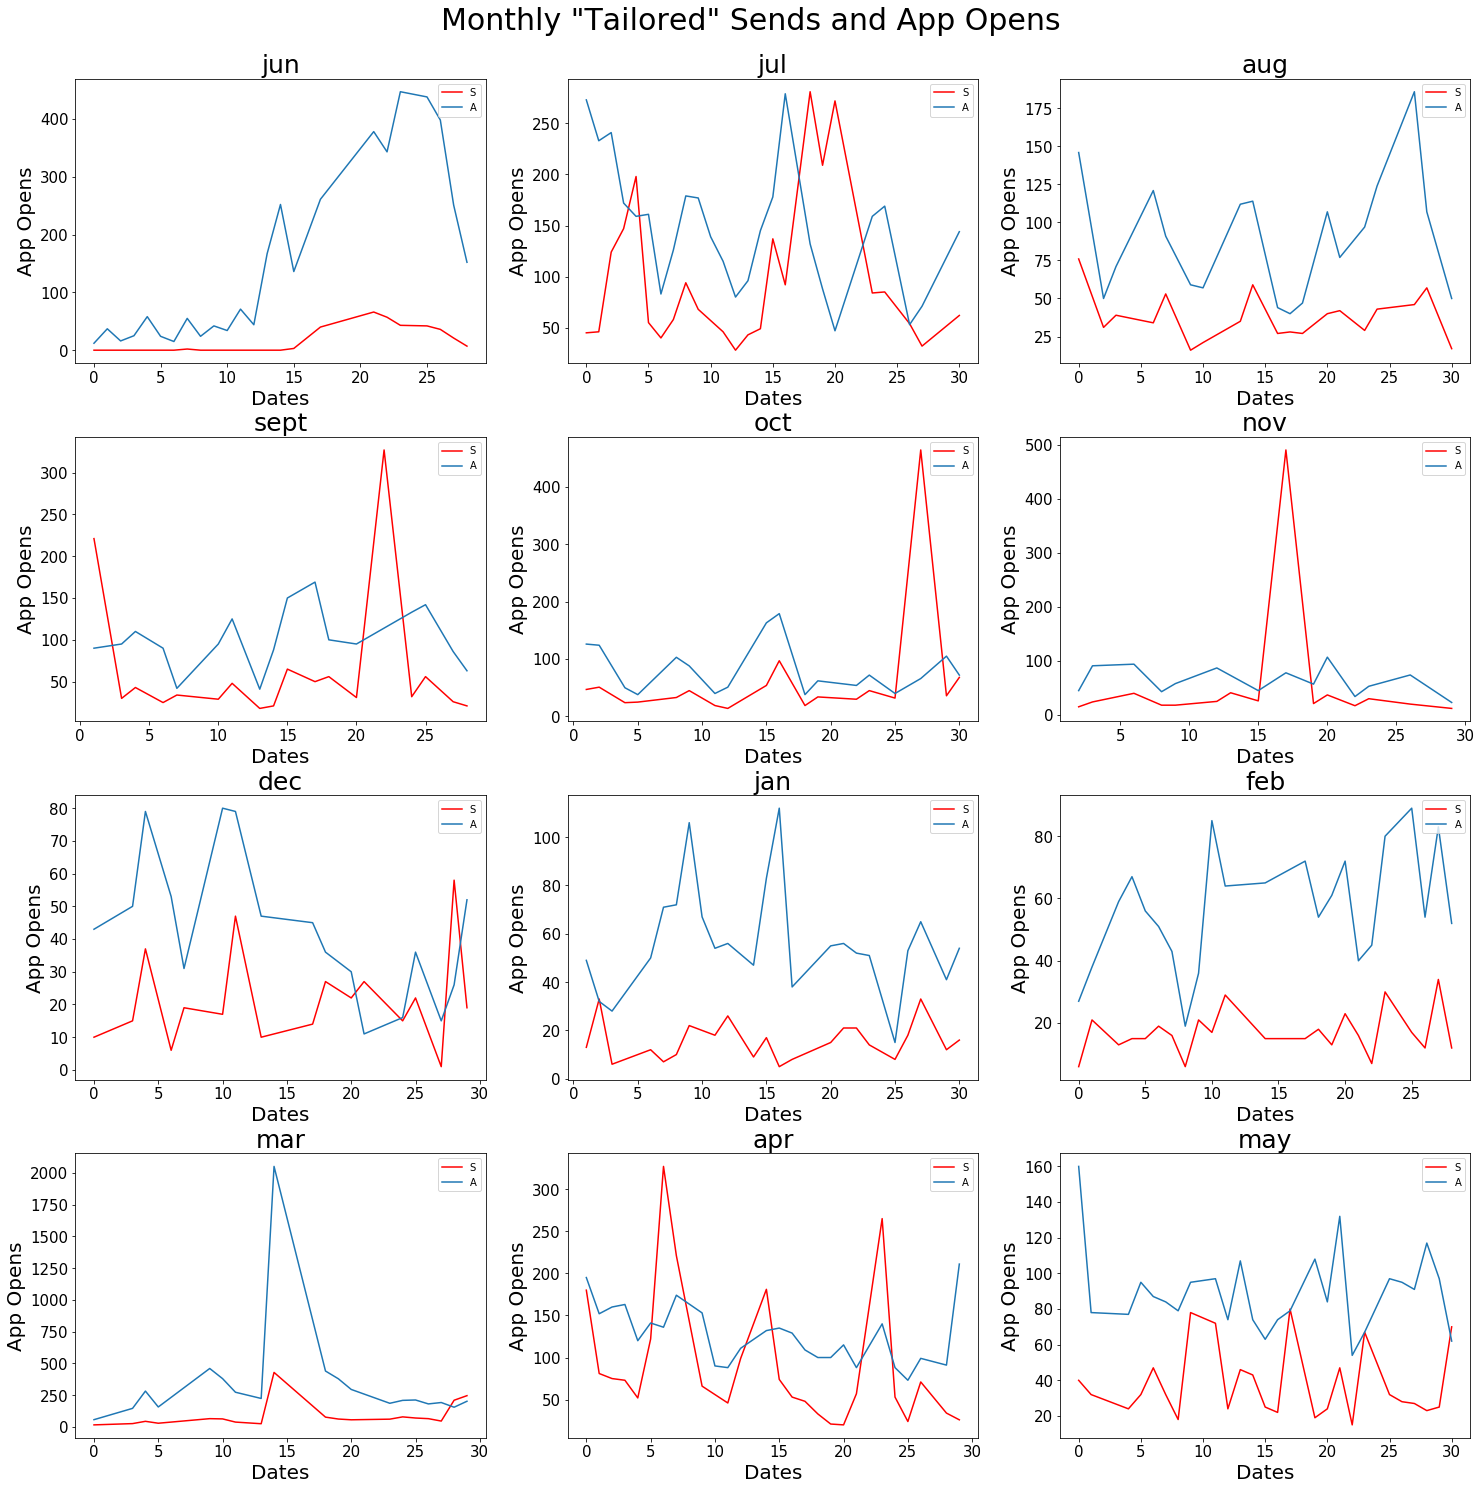

In [11]:
xaxs = 0
yaxs = 0

fig, axs = plt.subplots(4, 3, figsize=(25, 25))
fig.suptitle('Monthly "Tailored" Sends and App Opens', fontsize=30, y=.92)

m = 0
for month in monthdata:
    
    #dropping rows that are mass sends
    sendmean = month['Sends'].mean()
    newdf=month
    for i in range(len(newdf['Date'])):
        if month['Sends'][i] > sendmean:
            newdf=newdf.drop(i)
    
    #formatting
    axs[xaxs, yaxs].plot(newdf['Sends'], color='red')
    axs[xaxs, yaxs].plot(newdf['App Opens'])
    axs[xaxs, yaxs].set_title(monthlist[m],fontsize=25)
    axs[xaxs, yaxs].set_xlabel('Dates',fontsize=20)
    axs[xaxs, yaxs].set_ylabel('App Opens',fontsize=20)
    axs[xaxs, yaxs].tick_params(labelsize=15)
    axs[xaxs, yaxs].legend('SA',loc="upper right")
    
    m +=1
    yaxs +=1
    if yaxs == 3:
        yaxs = 0
        xaxs +=1
    #ax.legend(fontsize=10)

plt.subplots_adjust(hspace=.26)       

plt.show()
            

This seems like a strong relationship:
* July graphs have similar peaks and downturns
* August graphs have a similar but one is less volatile shapes
* Both graphs in March and October peak at the same points

## Determining the Strength of a Linear Relationship

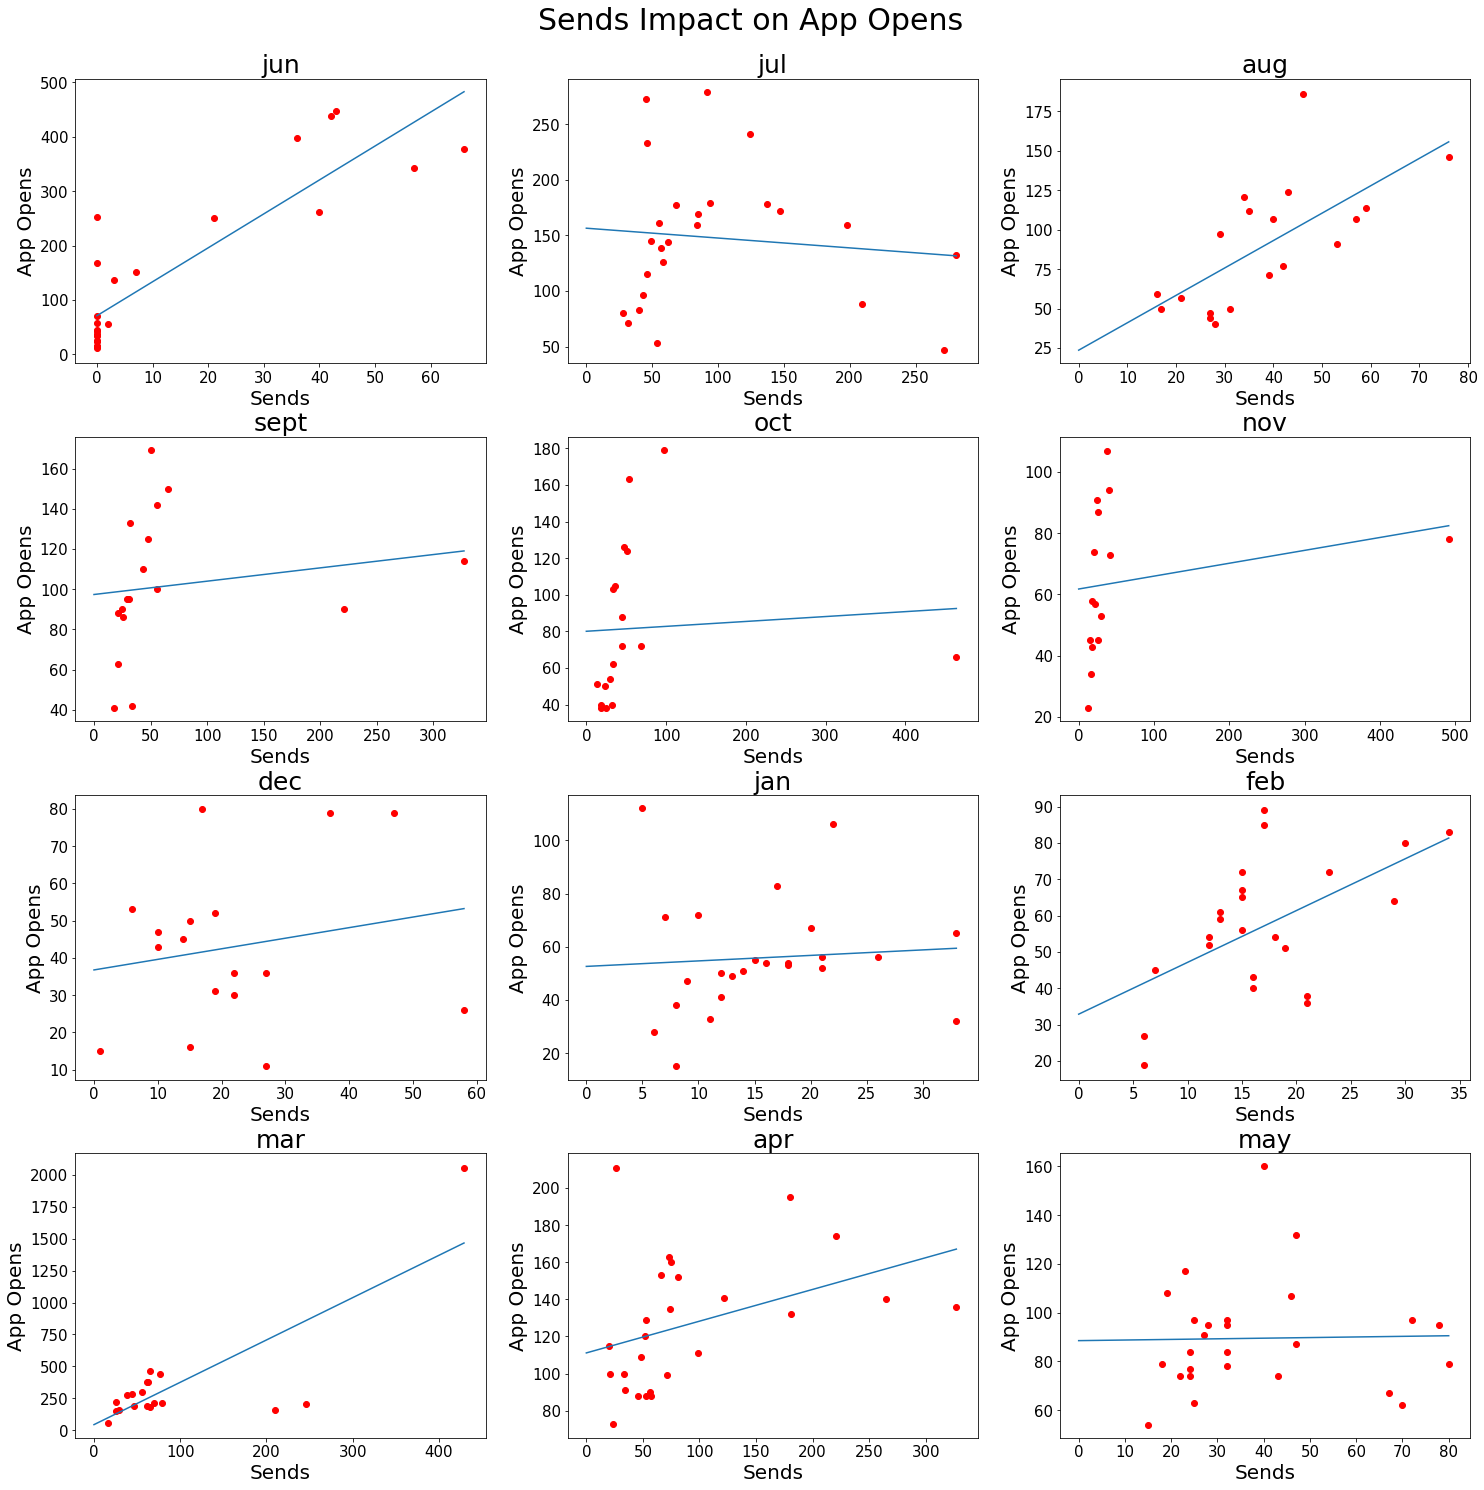

In [12]:
xaxs = 0
yaxs = 0

fig, axs = plt.subplots(4, 3, figsize=(25, 25))
fig.suptitle('Sends Impact on App Opens', fontsize=30,y=.92)

m = 0

for month in monthdata:
    #creating data
    sendmean = month['Sends'].mean()
    newdf=month
    for i in range(len(newdf['Date'])):
        if month['Sends'][i] > sendmean:
            newdf=newdf.drop(i)
    
    #creating line of best fit
    model = LinearRegression().fit(newdf[['Sends']],newdf['App Opens'])        
    score = model.coef_[0]
    intercept=model.intercept_
    x = np.linspace(0,newdf['Sends'].max(),100)
    y = score*x+intercept
    axs[xaxs, yaxs].plot(x, y)
    
    #creating scatter
    axs[xaxs, yaxs].scatter(newdf['Sends'],newdf['App Opens'],color='red')
    
    axs[xaxs, yaxs].set_title(monthlist[m],fontsize=25)
    axs[xaxs, yaxs].set_xlabel('Sends',fontsize=20)
    axs[xaxs, yaxs].set_ylabel('App Opens',fontsize=20)
    axs[xaxs, yaxs].tick_params(labelsize=15)
    m +=1
    yaxs +=1
    if yaxs == 3:
        yaxs = 0
        xaxs +=1
plt.subplots_adjust(hspace=.26)  
plt.show()

In [13]:
rlist=[]

m = -1
print('coefficient of determination')
print()
for month in monthdata:
    m +=1
    sendmean = month['Sends'].mean()
    newdf=month
    for i in range(len(newdf['Date'])):
        if month['Sends'][i] > sendmean:
            newdf=newdf.drop(i)
    
    cor = np.corrcoef(newdf['Sends'],newdf['App Opens'])[0][1]
    rlist.append(cor)
    print(monthlist[m], ':', cor)

coefficient of determination

jun : 0.875590881678144
jul : -0.10215492281105733
aug : 0.6756536374790917
sept : 0.15526518044964166
oct : 0.06338117247821856
nov : 0.20852748211360644
dec : 0.19128590102772242
jan : 0.07172128911313905
feb : 0.5478515929961625
mar : 0.7837660199061459
apr : 0.3842636820822593
may : 0.02175680297884601


In [14]:
print('med:',statistics.median(rlist))
print('mean:',statistics.mean(rlist))

med: 0.19990669157066443
mean: 0.3230757266243267


From the analysis above, we can note the following:
* The mean and median coefficient of determinations are very low, which would indicate a weak relationship
* However, the list of coefficient determination values shows really high values (June, August, February, and March), and really low values (October, January, May)
* When we look at October, we can see a clear outlier skewing the data. This can be seen in November too
* When we look at January, the point at (5,120) is skewing its regression

May generally might be scattered, but overall, we can see if removing those outliers can give us a more representative estimate of the relationship between the two variables.

### Dropping Outliers

#### An Important Note

Outliers are not a clearly defined term, and are usually significant in providing additional informational depth. However, it can clearly be seen that the months of October and November are significantly skewed by single points which show a high level of `Sends` but a disproportionately low amount of `App Opens`.

Therefore, the following section will attempt two different methods for removing potentional points skewing data and will analyze the information from the context all the actual data and the modified data. The unaltered data will be weighted more than the modified ones but the altered ones will be used to provide more depth to the understanding of the information

#### Method 1: Dropping the `Sends` and `App Opens` Outlier
In this analysis, we will find the two points farthest away from the mean on the x-axis and the mean on the y-axis and define them as outliers. 

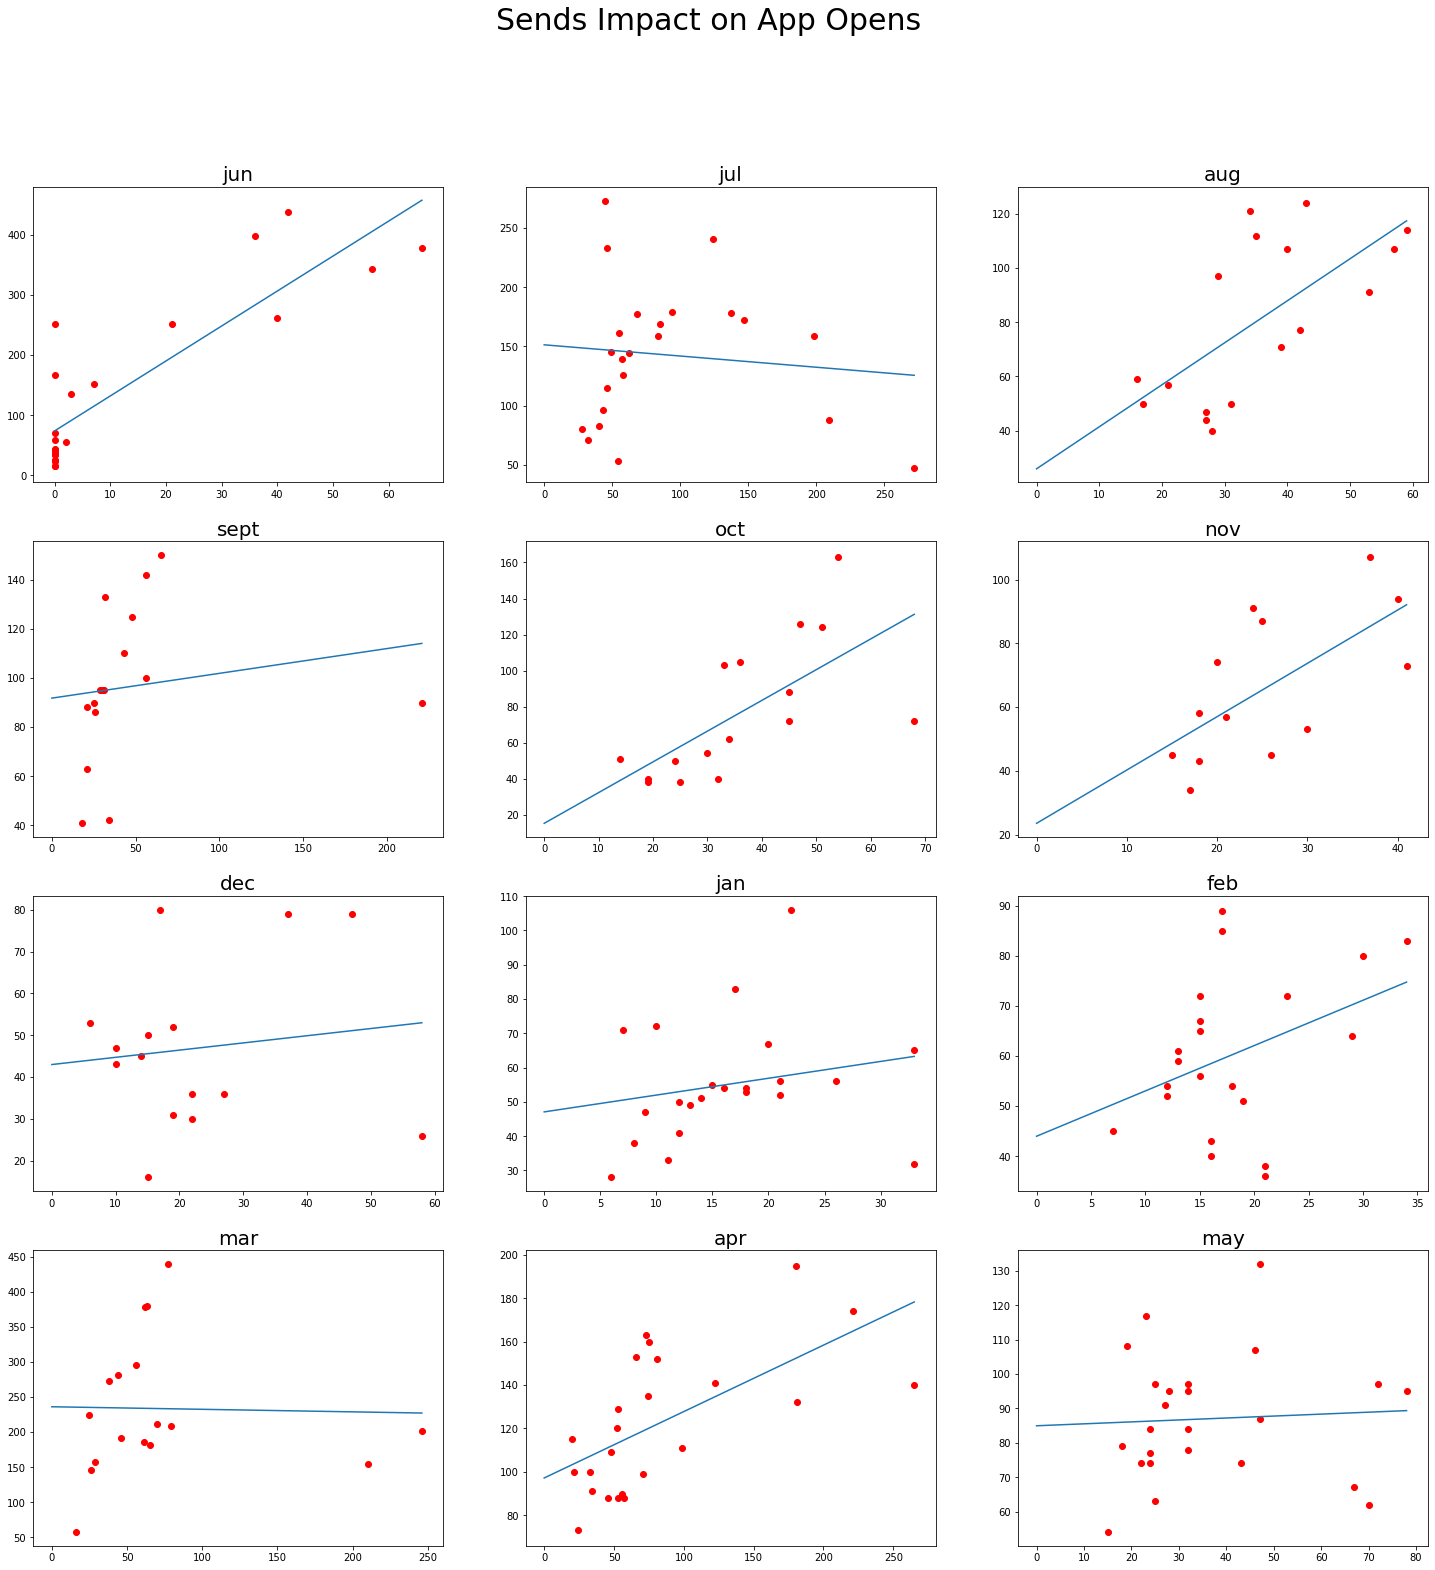

In [113]:
xaxs = 0
yaxs = 0

fig, axs = plt.subplots(4, 3, figsize=(25, 25))
fig.suptitle('Sends Impact on App Opens', fontsize=30)

m = 0

for month in monthdata:
    newdf=month
    
    #creating data
    sendmean = month['Sends'].mean()
    newdf=month
    for i in range(len(newdf['Date'])):
        if month['Sends'][i] > sendmean:
            newdf=newdf.drop(i)

 #dropping the Sends outlier 
    indexes = 0
    highestvalue=0
    for i in list ( newdf.index.values ):
        if abs(newdf['Sends'][i]-smean) > highestvalue:
            highestvalue = abs(newdf['Sends'][i]-smean)
            indexes=i
    newdf = newdf.drop(indexes)
    
    #dropping the App Open outlier 
    indexes = 0
    highestvalue=0
    for i in list ( newdf.index.values ):
        if abs(newdf['App Opens'][i]-amean) > highestvalue:
            highestvalue = abs(newdf['App Opens'][i]-amean)
            indexes=i
    df2 = newdf.drop(indexes)
    
    #creating line of best fit
    model = LinearRegression().fit(df2[['Sends']],df2['App Opens'])        
    score = model.coef_[0]
    intercept=model.intercept_
    x = np.linspace(0,df2['Sends'].max(),100)
    y = score*x+intercept
    axs[xaxs, yaxs].plot(x, y)
    
    #creating scatter
    axs[xaxs, yaxs].scatter(df2['Sends'],df2['App Opens'],color='red')

    axs[xaxs, yaxs].set_title(monthlist[m],fontsize=20)
    m +=1
    yaxs +=1
    if yaxs == 3:
        yaxs = 0
        xaxs +=1
plt.show()

We can see from the graphs above the impact of removing the two data points:
* October and November are better represented 
* March no longer shows the relationship it did before

In [103]:
r2list = []
m = -1
for month in monthdata:
    sendmean = month['Sends'].mean()
    newdf=month
    for i in range(len(newdf['Date'])):
        if month['Sends'][i] > sendmean:
            newdf=newdf.drop(i)
    smean=newdf['Sends'].mean()
    amean=newdf['App Opens'].mean()
    
 #dropping the send outlier 
    indexes = 0
    highestvalue=0
    for i in list ( newdf.index.values ):
        if abs(newdf['Sends'][i]-smean) > highestvalue:
            highestvalue = abs(newdf['Sends'][i]-smean)
            indexes=i
    newdf = newdf.drop(indexes)
    
    #dropping the app open outlier 
    indexes = 0
    highestvalue=0
    for i in list ( newdf.index.values ):
        if abs(newdf['App Opens'][i]-amean) > highestvalue:
            highestvalue = abs(newdf['App Opens'][i]-amean)
            indexes=i
    df2 = newdf.drop(indexes)

    m +=1
    
    cor = np.corrcoef(df2['Sends'],df2['App Opens'])[0][1]
    
    r2list.append(cor)
    print(monthlist[m], ':', cor)

jun : 0.8585088340033143
jul : -0.10274958797102898
aug : 0.6625310287492184
sept : 0.15604721909510547
oct : 0.6619380084886732
nov : 0.6431673361525133
dec : 0.5058257824872314
jan : 0.47616795643538357
feb : 0.3761616301020505
mar : -0.14933664307639585
apr : 0.6180949127128569
may : 0.05692029085342201


In [114]:
print('med:',statistics.median(r2list))
print('mean:',statistics.mean(r2list))

med: 0.43661561829752815
mean: 0.3867513879038253


Based on the mean and median, it is clear that a moderate relatinoship exists. However, it is stronger during certain months, which might indicate a seasonal preference for the app and will be further analyzed below.

#### Method 2: Removing the Two Max `Sends`

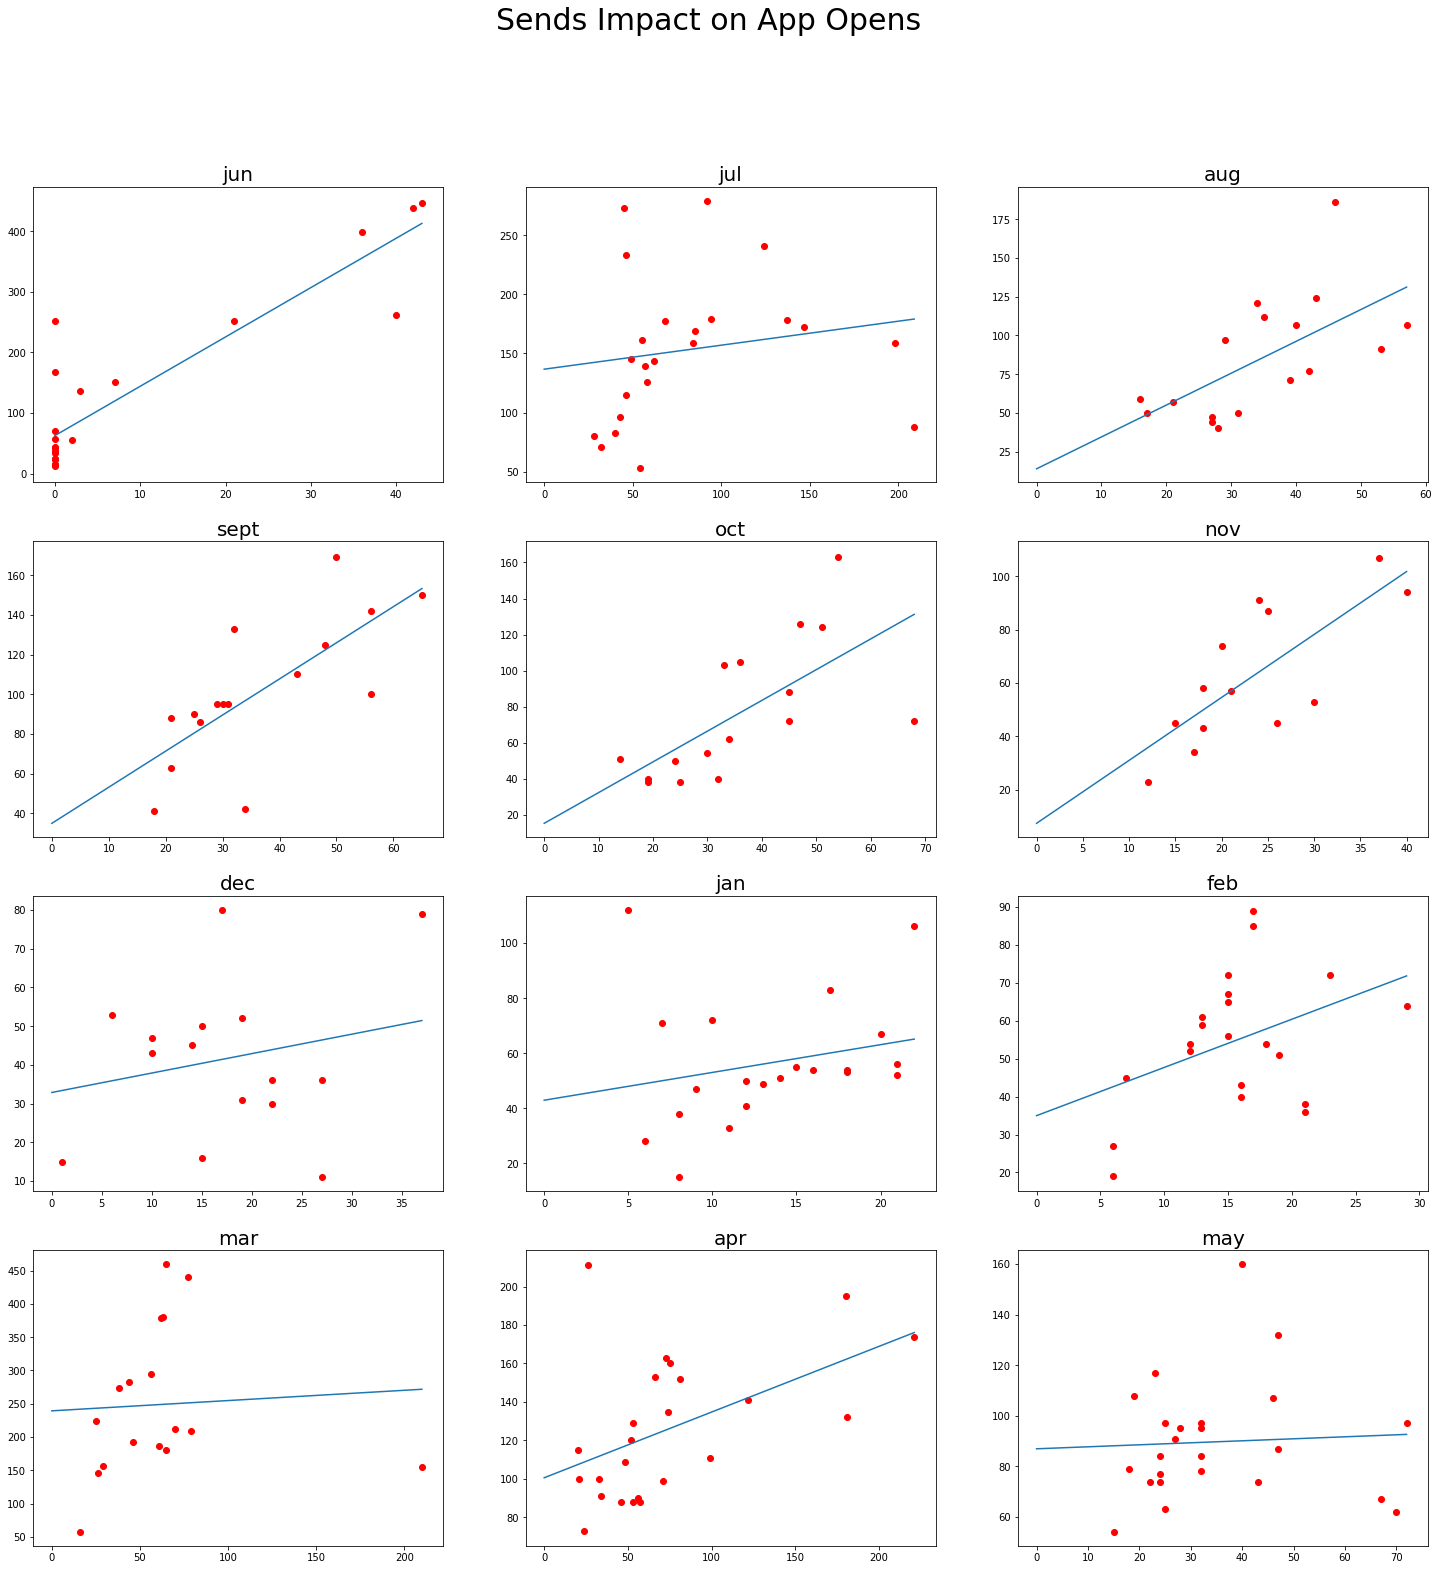

In [115]:
xaxs = 0
yaxs = 0

fig, axs = plt.subplots(4, 3, figsize=(25, 25))
fig.suptitle('Sends Impact on App Opens', fontsize=30)

m = 0

for month in monthdata:
    newdf=month
    
    #creating data
    sendmean = month['Sends'].mean()
    newdf=month
    for i in range(len(newdf['Date'])):
        if month['Sends'][i] > sendmean:
            newdf=newdf.drop(i)

    #dropping the send outlier 
    for x in [0,0]:
        newdf=newdf[newdf['Sends']!= newdf['Sends'].max()][:]
    
    df2=newdf
    
    #creating line of best fit
    model = LinearRegression().fit(df2[['Sends']],df2['App Opens'])        
    score = model.coef_[0]
    intercept=model.intercept_
    x = np.linspace(0,df2['Sends'].max(),100)
    y = score*x+intercept
    axs[xaxs, yaxs].plot(x, y)
    
    #creating scatter
    axs[xaxs, yaxs].scatter(df2['Sends'],df2['App Opens'],color='red')

    axs[xaxs, yaxs].set_title(monthlist[m],fontsize=20)
    m +=1
    yaxs +=1
    if yaxs == 3:
        yaxs = 0
        xaxs +=1
plt.show()

In [116]:
r2list = []
m = -1
for month in monthdata:
    sendmean = month['Sends'].mean()
    newdf=month
    for i in range(len(newdf['Date'])):
        if month['Sends'][i] > sendmean:
            newdf=newdf.drop(i)
    smean=newdf['Sends'].mean()
    amean=newdf['App Opens'].mean()
    
    for x in [0,0]:
        df2=newdf[newdf['Sends']!= newdf['Sends'].max()][:]

    m +=1
    
    cor = np.corrcoef(df2['Sends'],df2['App Opens'])[0][1]
    
    r2list.append(cor)
    print(monthlist[m], ':', cor)

jun : 0.8799542521971563
jul : -0.08756366001698683
aug : 0.6240418547836395
sept : 0.14214626699299568
oct : 0.7838407932159716
nov : 0.7067980105437212
dec : 0.4303766690127653
jan : 0.20301545343076888
feb : 0.47825967237187555
mar : -0.03236581111829237
apr : 0.4428545675822911
may : 0.06965858584999782


In [117]:
print('med:',statistics.median(r2list))
print('mean:',statistics.mean(r2list))

med: 0.43661561829752815
mean: 0.3867513879038253


June, August, September, October, November, and February all have coefficients of determination values above .55, indicating strong, positive relationship. 

The other six months, however, do not demonstrate this, while July has a negative relationship. To better understand this, we can refer back to the graphs. 
* July has two additional data points that were dragging down the data
* January, March, April, May, December have weaker relationships, but a clear upward scatter is visible from the graph

## Determining the Strength of a Non-Linear Relationship

We could use a Spearman Correlation to whether a nonlienear relationship is plausible.

In [67]:
m = -1
splist1 = []
plist1 = []
for month in monthdata:
    m +=1
    sendmean = month['Sends'].mean()
    newdf=month
    for i in range(len(newdf['Date'])):
        if month['Sends'][i] > sendmean:
            newdf=newdf.drop(i)
    
    sp = spearmanr(newdf['Sends'],newdf['App Opens'])
    splist1.append(sp.correlation)
    plist1.append(sp.pvalue)
    print(monthlist[m], 'r: {:.4f}'.format(sp.correlation), 'p-value: {:.4f}'.format(sp.pvalue))

jun r: 0.8041 p-value: 0.0000
jul r: 0.2420 p-value: 0.2438
aug r: 0.7413 p-value: 0.0003
sept r: 0.6805 p-value: 0.0019
oct r: 0.7693 p-value: 0.0002
nov r: 0.6816 p-value: 0.0051
dec r: -0.0148 p-value: 0.9551
jan r: 0.2517 p-value: 0.2355
feb r: 0.4084 p-value: 0.0530
mar r: 0.3624 p-value: 0.1273
apr r: 0.5260 p-value: 0.0058
may r: 0.1356 p-value: 0.5090


In [71]:
print('med:','r: {:.4f}'.format(statistics.median(splXist1)),'p: {:.4f}'.format(statistics.median(plist1)))
print('mean:','r: {:.4f}'.format(statistics.mean(splist1)),'p: {:.4f}'.format(statistics.mean(plist1)))

med: r: 0.4672 p: 0.0294
mean: r: 0.4657 p: 0.1781


From the medians above, we can see that the non-linear relationship is moderately strong, and based on the relatively small p-value, this is not due to chance. The mean has a slightly higher p-value, but the r-value is approximately the same.

## Next Steps
This data demonstrates that there is a moderately strong relationship between the two variables. That being said, the number of sends is below 100 while app opens are above 140. This could indicate one of two things:
* Individuals are opening their apps more than once
* Personalized sends may be only causing some of the app opens

Therefore, the data is right now inconclusive but a strong line of research to pursue. The following steps are suggested:
* Sending additional tailored messages and attempt to better intrapolate
* Identify if there are direct opens or influenced opens
* Create a control group and experimental group to compare results

# Impact of Day of the Week on App Opens

## Creating Day Data Frames

In [163]:
stdf=pandas.DataFrame()
for i in range(len(ydf)):
    if i % 7 == 0:
        stdf = stdf.append(ydf.loc[i])
        
sdf=pandas.DataFrame()
for i in range(len(ydf)):
    if i % 7 == 1:
        sdf = sdf.append(ydf.loc[i])
        
mdf=pandas.DataFrame()
for i in range(len(ydf)):
    if i % 7 == 2:
        mdf = mdf.append(ydf.loc[i])
        
tdf=pandas.DataFrame()
for i in range(len(ydf)):
    if i % 7 == 3:
        tdf = tdf.append(ydf.loc[i])
        
wdf=pandas.DataFrame()
for i in range(len(ydf)):
    if i % 7 == 4:
        wdf = wdf.append(ydf.loc[i])
        
thdf=pandas.DataFrame()
for i in range(len(ydf)):
    if i % 7 == 5:
        thdf = thdf.append(ydf.loc[i])
        
fdf=pandas.DataFrame()
for i in range(len(ydf)):
    if i % 7 == 6:
        fdf = fdf.append(ydf.loc[i])

daylist=[stdf,sdf,mdf,tdf,wdf,thdf,fdf]

for d in daylist:
    d.reset_index(drop=True, inplace=True)

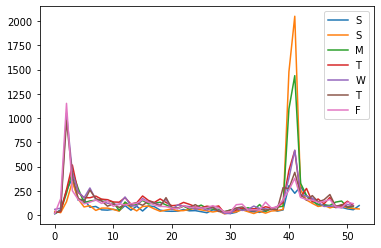

In [164]:
for x in daylist:
    plt.plot(x['App Opens'])
plt.legend('SSMTWTF')
plt.show()

It is unclear whether days of the week impacts the app opens from the graph above because of the two spikes. Therefore, we will remove those points to get a better look at the relative separation.

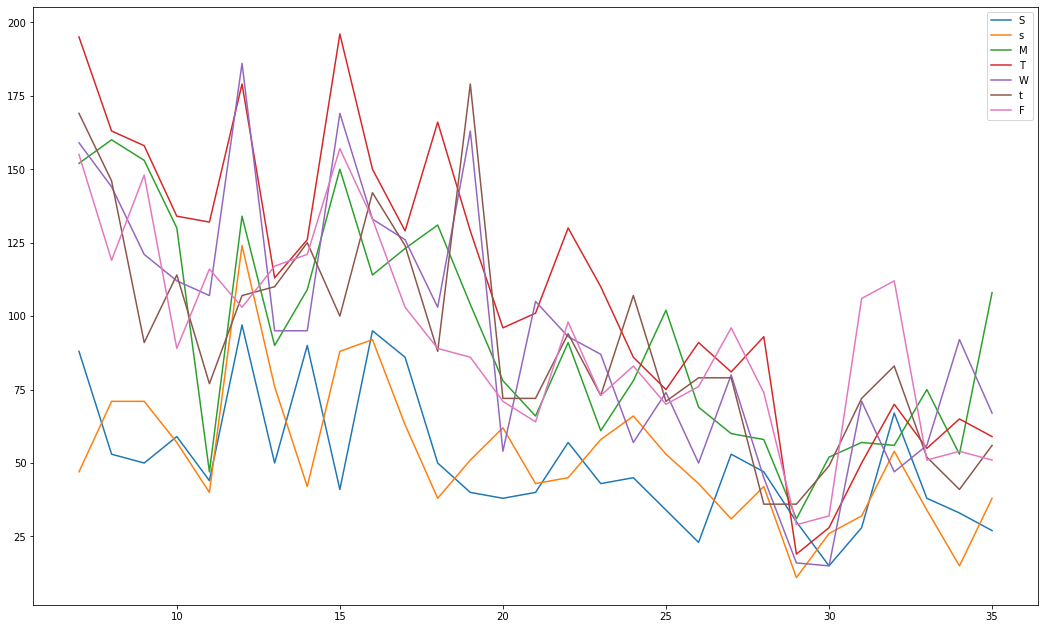

In [216]:
plt.figure(figsize=(18, 11))
for x in daylist:
    plt.plot(x['App Opens'].loc[7:35])
plt.legend('SsMTWtF')
plt.show()

From this graph, we can see that:
* Saturday and Sunday are consistently lower than the other days
* Tuesday is generally higher

We can attempt to normalize to determine whether there is a regular percentage of `App Opens` on a given day.

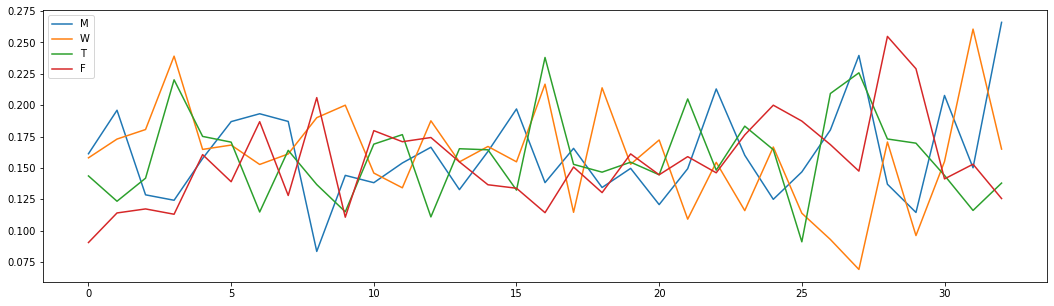

In [227]:
plt.figure(figsize=(18, 5))
for d in [daylist[2], daylist[4],daylist[5],daylist[6]]: # for each day
    #d = sundf
    #date= index
    thedf = [] #create a dataframe
    for date in range(len(fdf)): #for each date
        
        #find the wktotal
        wkttl = 0 
        for day in daylist:
            wkttl += day['App Opens'][date]
        
        #find the percentage 
        per = d['App Opens'][date]/wkttl
        thedf.append(per)#append to date
    
    #plot dataframe  
    
    plt.plot(thedf[3:36])

plt.legend('MWTF')
plt.show()

Besides the trends stated above, we cannot identify any other relationship between day of the week and `App Opens`

# Impact of Season on App Opens

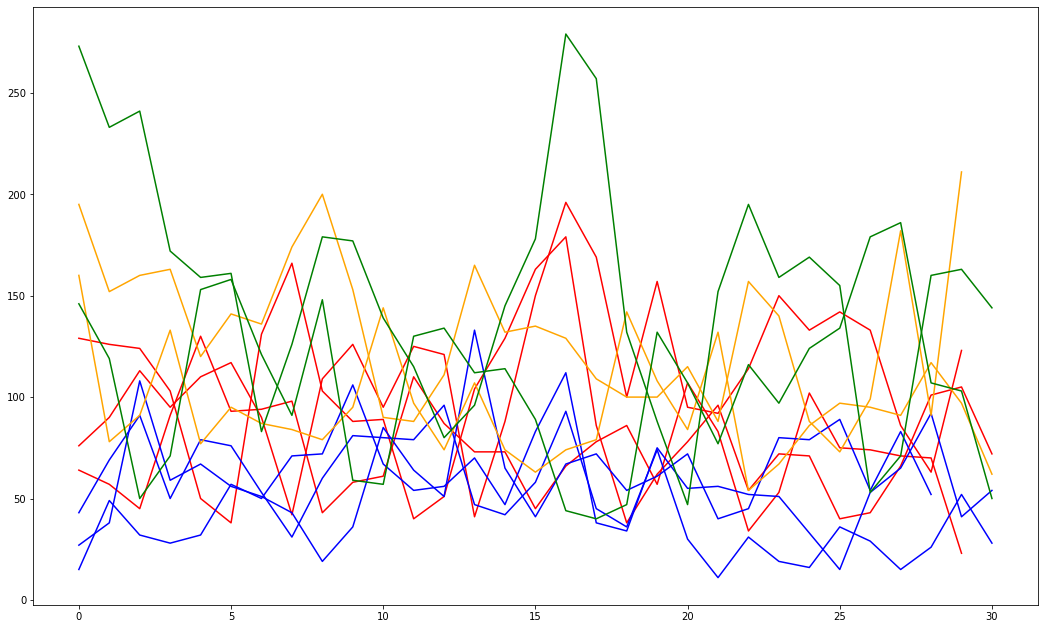

In [242]:
plt.figure(figsize=(18,11))
falldata = [ septdf, octdf, novdf ]
winterdata=[decdf, jandf, febdf]
springdata=[ aprdf, maydf]
summerdata=[juldf,augdf]

for m in falldata:
    df=m
    plt.plot(m['App Opens'], color='red')
for m in winterdata:
    df=m
    plt.plot(m['App Opens'], color='blue')    
for m in springdata:
    df=m
    plt.plot(m['App Opens'], color='orange')
for m in summerdata:
    df=m
    plt.plot(m['App Opens'], color='green')

    
plt.show()

Based on the graph above, we can see:
* Winter has the lowest nubmer of `App Opens`
* Summer has the greatest number of `App Opens`
* There appears to be a slight increase in usage at around the 15th of the month, but overall, there is no relationship between date of the month and `App Opens`

This could possibly indicate a trend of people using the PepTalkHer app more during warmer weather. 

In [253]:
falldata = [ septdf, octdf, novdf ]
winterdata=[decdf, jandf, febdf]
springdata=[ aprdf, maydf]
summerdata=[juldf,augdf]

print('Fall')
print('mean, median')
for m in falldata:
    print('{:.2f}'.format(m['App Opens'].mean()), m['App Opens'].median())
    
print()
print('Winter')
print('mean, median')
for m in winterdata:
    print('{:.2f}'.format(m['App Opens'].mean()), m['App Opens'].median())
print()
print('Spring')
print('mean, median')
for m in springdata:
    print('{:.2f}'.format(m['App Opens'].mean()), m['App Opens'].median())
print()
print('Summer')
print('mean, median')
for m in summerdata:
    print('{:.2f}'.format(m['App Opens'].mean()), m['App Opens'].median())

Fall
mean, median
111.37 111.5
90.23 88.0
73.37 73.0

Winter
mean, median
50.84 47.0
55.32 54.0
61.76 59.0

Spring
mean, median
133.23 133.5
94.29 91.0

Summer
mean, median
154.23 159.0
106.29 112.0


From this data, we can see that the mean and median are extremely cloes for all of the data points, indicating that the numbers are good representatives of the months data. Additionally, the information above verifies the trend that we saw in the graph. In the winter, numbers dwindled down to only 50 App Opens, while in the Summer, number were consistently above 100. 